In [8]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error, mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sysidentpy.general_estimators import NARX
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor



### Data 
Using data from 28R30S model simulation, 'U_core_T4B_08June23.csv'.<br>
Input (30) : Current of Stator 1 to 30 <br>
Output (1): Total torque generated. 

In [13]:

url = "C:/Users/mfavre4/Desktop/System_Identification/Python_Package/Data/U_core_T4B_08June23.csv"
df = pd.read_csv(url, sep=",")
dataset = df.astype(float)

#Inputs - Current of each poles
ds_I = (dataset.loc[:,"I_1":"I_30"])

#Output - Total torque
frames = [(dataset.loc[0:701,"totalTorque_0":"totalTorque_29"]),(dataset.loc[0:701,'totalTorque_30']),(dataset.loc[0:701,'Total_Torque']),(dataset.loc[0:701,'Solved']) ]
ds_T = pd.concat(frames,axis=1)

print(ds_T.shape)

I_id, I_val, xlags = [None for n in range(ds_I.shape[1])],[None for n in range(ds_I.shape[1])],[None for n in range(ds_I.shape[1])]
T_id, T_val, ylags = [None for n in range(ds_T.shape[1])],[None for n in range(ds_T.shape[1])],[None for n in range(ds_T.shape[1])]


for i,c in enumerate(ds_I):
    #Creating id arrays with the current of each pole
    exec(str(c)+'_id'+'= ds_I[str(c)][0:492].values.reshape(-1, 1)')
    exec('I_id[i]='+str(c)+'_id')
    
    #Creating validation arrays with the current of each pole
    exec(str(c)+'_val'+'= ds_I[str(c)][492:702:].values.reshape(-1, 1)')
    exec('I_val[i]='+str(c)+'_val')

#Input id and validation sets
x_id = np.concatenate([x for x in I_id], axis =1 )  
x_val = np.concatenate([x for x in I_val], axis =1 ) 

#Output id and validation sets
y_id, y_val = ds_T['Total_Torque'][0:492].values.reshape(-1, 1), ds_T['Total_Torque'][492::].values.reshape(-1, 1)

#Lags for each inputs [[1,2], [1,2]...]
for i,x in enumerate(xlags): xlags[i] = ([i for i in range(1,2)])
    
ylags=[70]

print(xlags

(702, 33)
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]


In [10]:
deg = 1
basis_function = Polynomial(degree=deg)
model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=ylags,
    xlag=xlags,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_id, y=y_id)



C:\Users\mfavre4\AppData\Local\anaconda3\Lib\site-packages\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


Polynomial degree: 1
Input lags: [1]
Output lags: [70]
RRSE: 1.229
 
  Regressors   Parameters             ERR
0          1   2.5087E+04  9.58251028E-01
1    x5(k-1)   9.0514E-01  9.49444944E-04
2   x28(k-1)  -8.3801E-01  7.27832444E-04
3    x4(k-1)  -5.7440E-01  3.02311869E-04
4   x27(k-1)  -5.2599E-01  3.02152428E-04
5   x11(k-1)  -6.2830E-01  2.59187058E-04
6   x23(k-1)  -5.5642E-01  2.87906939E-04
7    x1(k-1)  -4.9177E-01  2.30590220E-04
8    x2(k-1)  -5.0898E-01  2.29610513E-04
9   x26(k-1)   4.3392E-01  2.10487654E-04


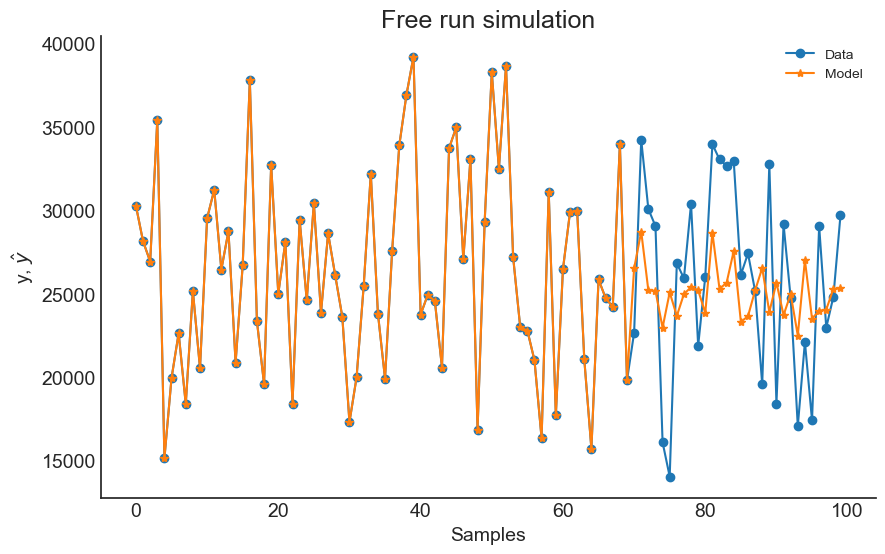

In [11]:

yhat = model.predict(X=x_val, y=y_val)
rrse = root_relative_squared_error(y_val, yhat)

print('Polynomial degree: '+str(deg))
print('Input lags: '+str(xlags[0]))
print('Output lags: '+str(ylags))
print('RRSE: '+str(round(rrse,3)))
print(' ')

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_val[0:100], yhat=yhat[0:100], n=1000)


### Non-Linear Autoregressive exogenous inputs (NARX) model

#### CatBoost Regressor

MSE:  21088920.893894985


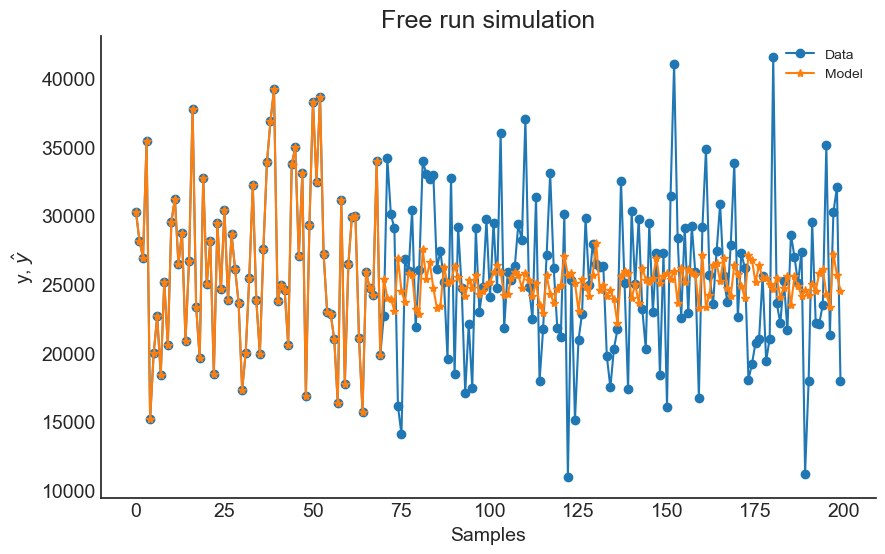

In [14]:
from sysidentpy.general_estimators import NARX
basis_function = Fourier(degree=1)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=8
        ),
    xlag=xlags,
    ylag=ylags,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={'verbose': False}
)

catboost_narx.fit(X=x_id, y=y_id)
yhat = catboost_narx.predict(X=x_val, y=y_val, steps_ahead=1)
print("MSE: ", mean_squared_error(y_val, yhat))
plot_results(y=y_val, yhat=yhat, n=200)
